# Stock Market Trend Analysis and Forecasting

## Introduction
This notebook provides a comprehensive guide to analyzing and forecasting stock market trends using time series analysis techniques. It's designed for interns to gain hands-on experience with financial data analytics, model development, and results interpretation.

**Learning Objectives:**
- Load and preprocess financial time series data
- Explore historical patterns and visualize stock data
- Identify trends and seasonality components
- Implement various time series forecasting models
- Evaluate model performance and make predictions
- Interpret results in a financial context


## 1. Setting Up the Environment

First, let's install and import all necessary libraries for our analysis.

In [50]:
# Install required packages if not already installed
!pip install pandas matplotlib seaborn yfinance statsmodels prophet pmdarima tensorflow

  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


  You can safely remove it manually.


In [51]:
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings

# Statistical and time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Set plotting style and ignore warnings
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Collection

We'll use the `yfinance` library to download historical stock price data for analysis.

In [53]:
# Define function to fetch stock data
def get_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data for a given ticker and date range.
    
    Parameters:
        ticker (str): Stock ticker symbol
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        
    Returns:
        DataFrame: Stock data
    """
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        print(f"Successfully downloaded data for {ticker}")
        return stock_data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

In [54]:
# Set parameters for data collection
ticker = "AAPL"  # Apple Inc. as an example
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')  # 5 years of data

# Download stock data
stock_data = get_stock_data(ticker, start_date, end_date)

# Display the first few rows of the data
stock_data.head()

[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-06-04,78.329338,79.131292,77.955089,78.832386,87560400
2020-06-05,80.560211,80.620965,78.550461,78.579622,137250400
2020-06-08,81.036537,81.070563,79.544415,80.256454,95654400
2020-06-09,83.595512,83.989199,80.684170,80.715764,147712400
2020-06-10,85.746208,86.215230,84.105842,84.545702,166651600


## 3. Data Exploration and Preprocessing

Let's explore the dataset and perform necessary preprocessing steps.

In [55]:
# Check for missing values
print("Missing values in the dataset:")
print(stock_data.isnull().sum())

# Check dataset information
print("\nDataset information:")
stock_data.info()

# Summary statistics
print("\nSummary statistics:")
stock_data.describe()

Missing values in the dataset:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-06-04 to 2025-06-02
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1255 non-null   float64
 1   (High, AAPL)    1255 non-null   float64
 2   (Low, AAPL)     1255 non-null   float64
 3   (Open, AAPL)    1255 non-null   float64
 4   (Volume, AAPL)  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB

Summary statistics:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,164.321062,166.006163,162.443943,164.160646,8.078038e+07
std,38.179689,38.364282,37.891117,38.094942,4.191317e+07
min,78.329338,79.131292,77.955089,78.579622,2.323470e+07
25%,136.922234,139.392619,134.935192,136.720491,5.239195e+07
50%,162.264191,163.728819,160.141743,161.654368,7.046270e+07
75%,188.222137,189.675977,186.846649,188.102508,9.563880e+07
max,258.396667,259.474086,257.010028,257.568678,3.743368e+08


In [56]:
# We'll focus on the 'Adj Close' price for our analysis
stock_data = stock_data[['Close', 'Volume']]
stock_data.rename(columns={'Close': 'Price'}, inplace=True)

# Calculate daily returns
stock_data['Returns'] = stock_data['Price'].pct_change() * 100

# Calculate moving averages
stock_data['MA_50'] = stock_data['Price'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Price'].rolling(window=200).mean()

# Drop NaN values
stock_data = stock_data.dropna()

# Display the first few rows after preprocessing
stock_data.head()

Price,Price,Volume,Returns,MA_50,MA_200
Ticker,AAPL,AAPL,,,
Date,,,,,
2021-03-19,117.225365,185549500,-0.448027,126.370877,113.047752
2021-03-22,120.547043,111912300,2.833583,126.227563,113.258841
2021-03-23,119.716629,95467100,-0.688871,126.045595,113.454623
2021-03-24,117.323059,88530500,-1.999363,125.875652,113.636056
2021-03-25,117.811539,98844700,0.416354,125.718990,113.807136


## 4. Data Visualization

Let's create visualizations to better understand the historical patterns and trends in the stock price.

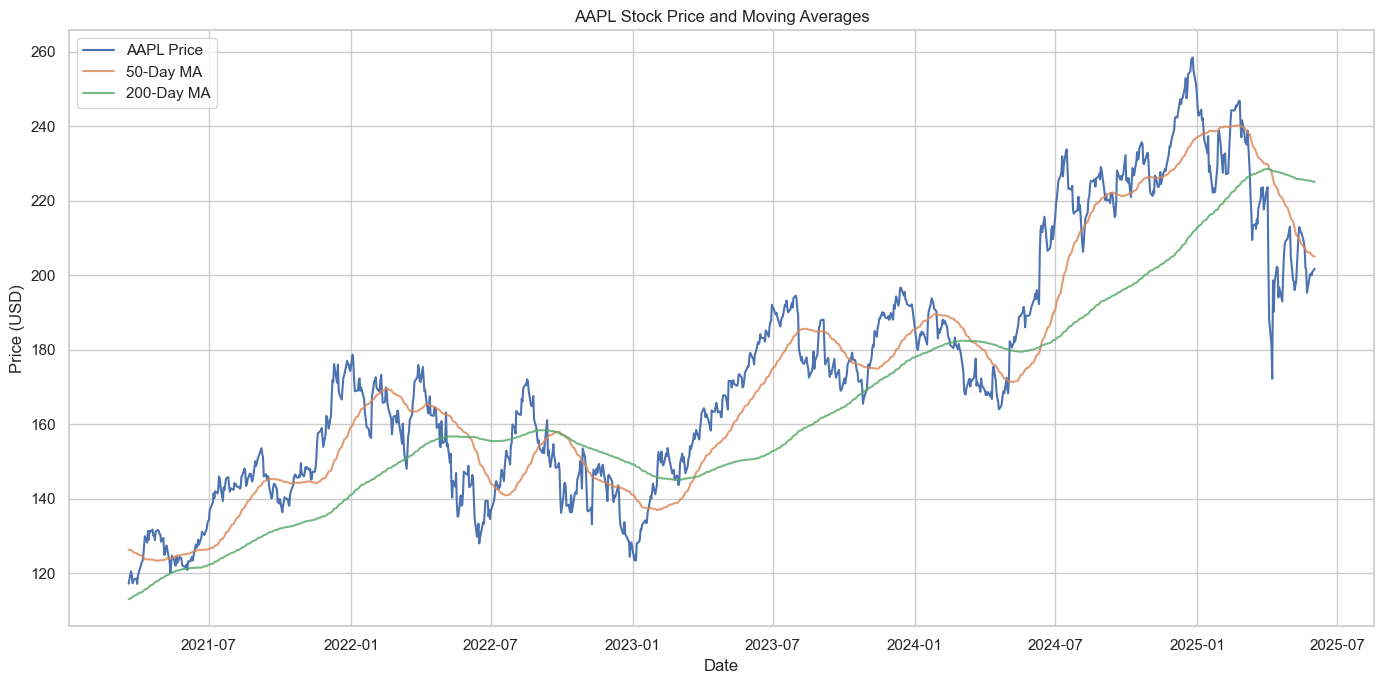

In [57]:
# Plot the stock price over time
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Price'], label=f'{ticker} Price')
plt.plot(stock_data.index, stock_data['MA_50'], label='50-Day MA', alpha=0.8)
plt.plot(stock_data.index, stock_data['MA_200'], label='200-Day MA', alpha=0.8)
plt.title(f'{ticker} Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

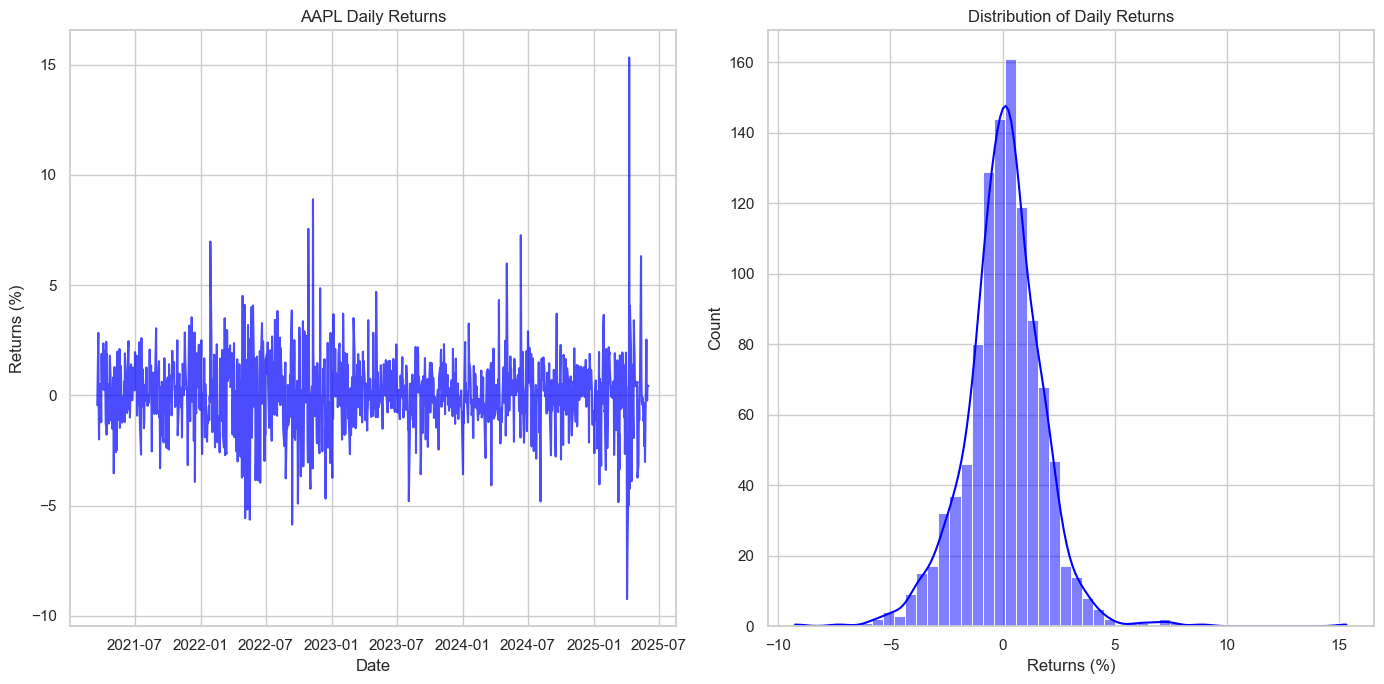

In [58]:
# Plot daily returns distribution
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(stock_data.index, stock_data['Returns'], color='blue', alpha=0.7)
plt.title(f'{ticker} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(stock_data['Returns'], kde=True, color='blue', bins=50)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns (%)')
plt.tight_layout()
plt.show()

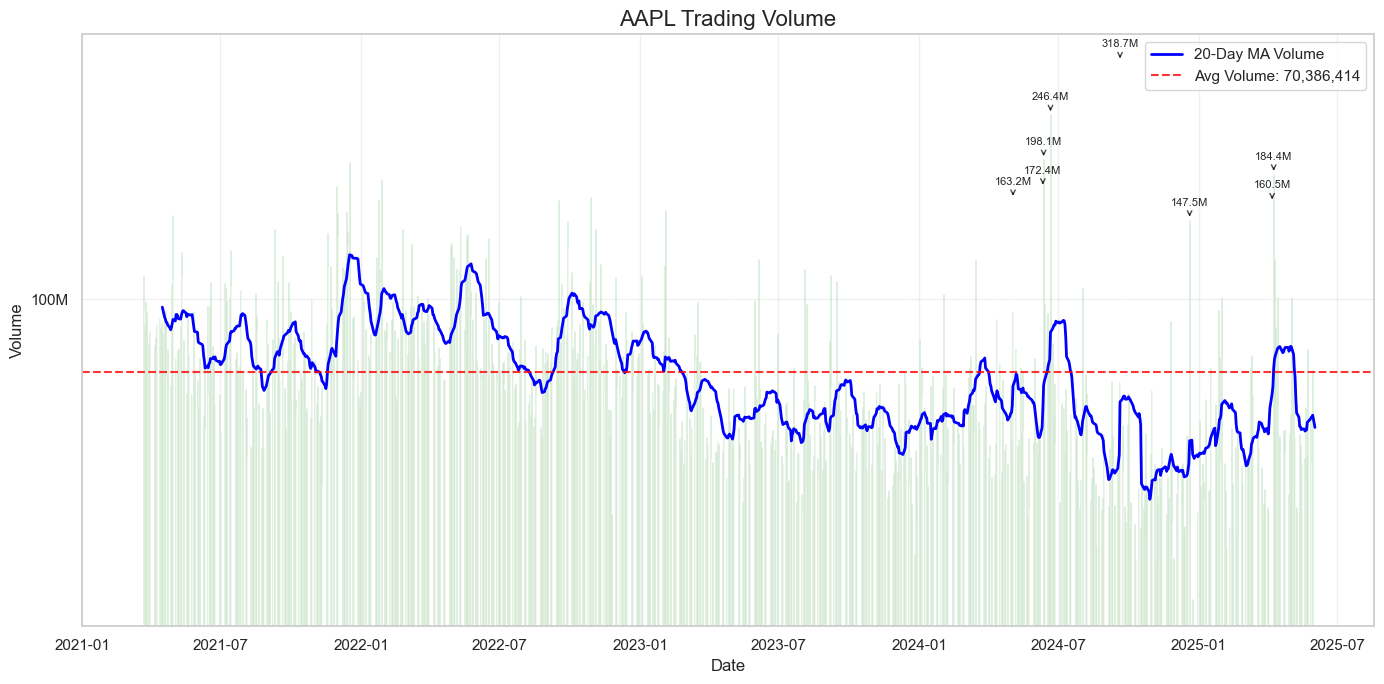

In [62]:
from matplotlib.ticker import FuncFormatter

# Plot trading volume with additional analysis
plt.figure(figsize=(14, 7))

# Create a subplot for better layout
ax = plt.subplot(1, 1, 1)

# Access Volume using the correct MultiIndex format
volume_bars = ax.bar(stock_data.index, stock_data[('Volume', 'AAPL')], color='green', alpha=0.5)

# Add 20-day moving average of volume
volume_ma = stock_data[('Volume', 'AAPL')].rolling(window=20).mean()
ax.plot(stock_data.index, volume_ma, color='blue', linewidth=2, label='20-Day MA Volume')

# Calculate and add horizontal line for average volume
avg_volume = stock_data[('Volume', 'AAPL')].mean()
ax.axhline(y=avg_volume, color='red', linestyle='--', alpha=0.8, label=f'Avg Volume: {int(avg_volume):,}')

# Add annotations for remarkable volume spikes
threshold = stock_data[('Volume', 'AAPL')].mean() * 2  # 2x average as threshold for spikes
volume_spikes = stock_data[stock_data[('Volume', 'AAPL')] > threshold]
for date, row in volume_spikes.iterrows():
    if date.year >= datetime.today().year - 1:  # Only annotate recent spikes
        ax.annotate(f"{row[('Volume', 'AAPL')]/1e6:.1f}M", 
                    xy=(date, row[('Volume', 'AAPL')]),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center', 
                    fontsize=8,
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))

# Format the plot
ax.set_title(f'{ticker} Trading Volume', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yscale('log')  # Using log scale for better visualization

# Format y-axis labels to show millions
def millions(x, pos):
    return f'{int(x/1e6)}M'
ax.yaxis.set_major_formatter(FuncFormatter(millions))

plt.tight_layout()
plt.show()

## 5. Time Series Analysis

Let's decompose the time series into trend, seasonality, and residual components.

<Figure size 1400x1000 with 0 Axes>

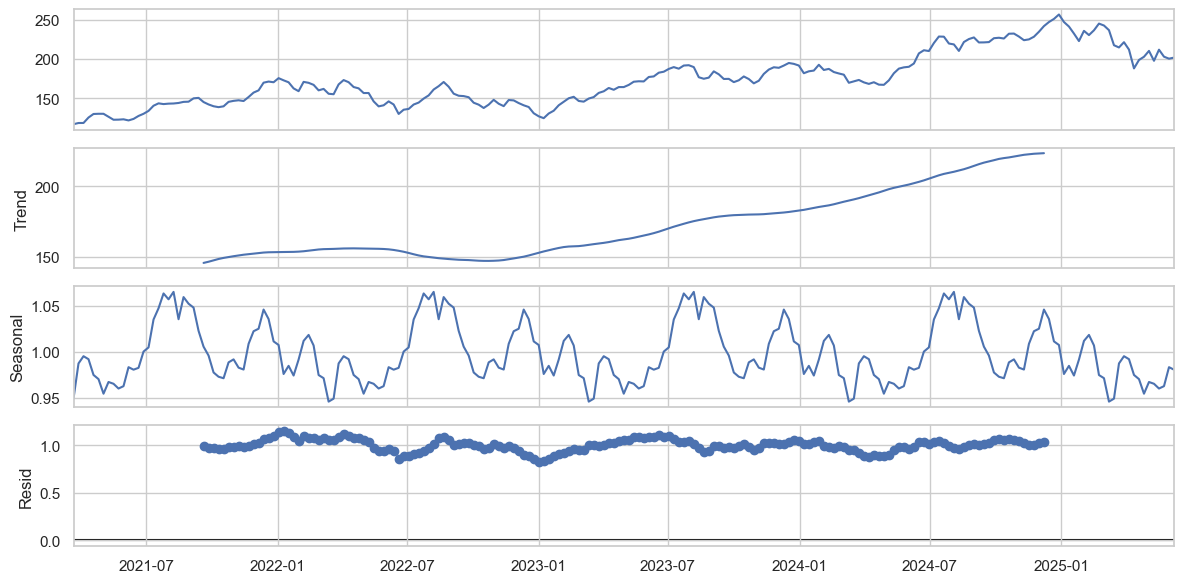

In [63]:
# Time series decomposition
price_series = stock_data['Price'].resample('W').mean()  # Weekly resampling for better visualization
decomposition = seasonal_decompose(price_series, model='multiplicative', period=52)  # 52 weeks in a year

# Plot the decomposition
fig = plt.figure(figsize=(14, 10))
fig = decomposition.plot()
plt.tight_layout()
plt.show()

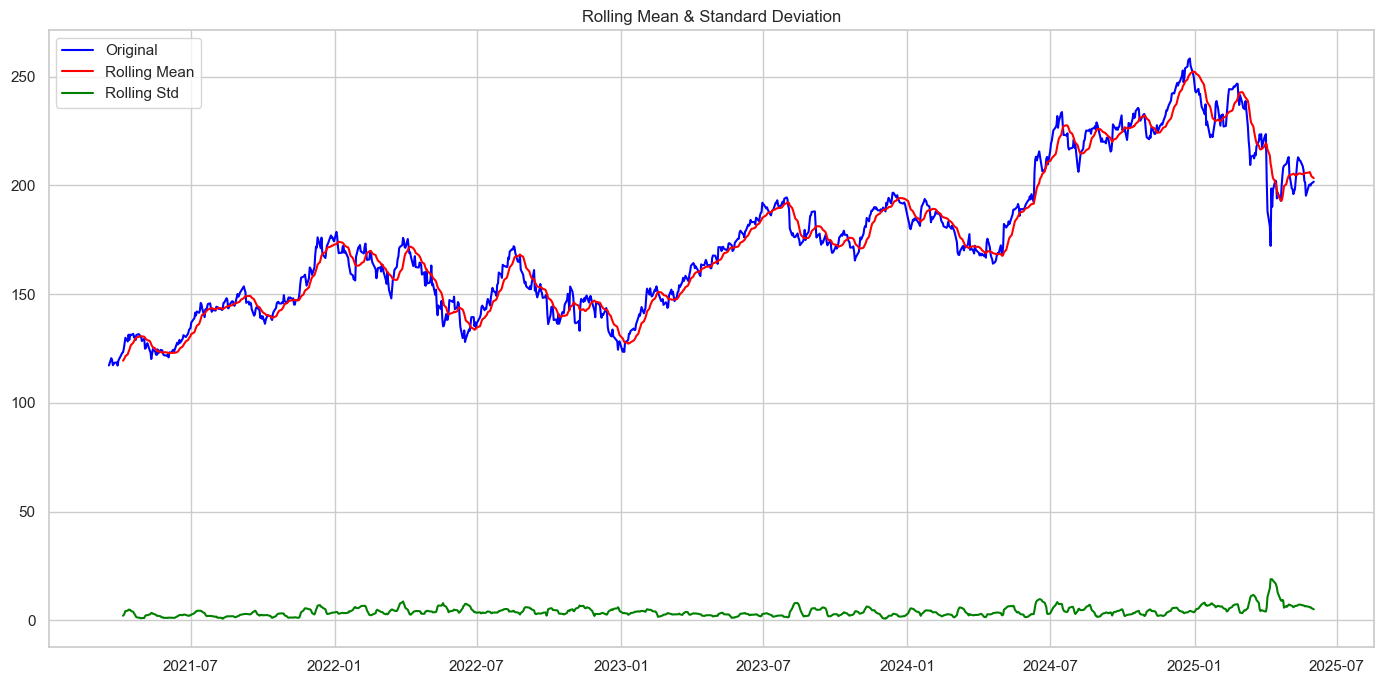

Results of Dickey-Fuller Test:
Test Statistic                   -1.883484
p-value                           0.339870
#Lags Used                        0.000000
Number of Observations Used    1055.000000
Critical Value (1%)              -3.436564
Critical Value (5%)              -2.864283
Critical Value (10%)             -2.568231
dtype: float64

Result: The series is non-stationary (fail to reject null hypothesis)


In [64]:
# Check stationarity with Augmented Dickey-Fuller test
def test_stationarity(timeseries, window=12):
    """
    Test stationarity using the Augmented Dickey-Fuller test and rolling statistics.
    
    Parameters:
        timeseries (Series): Time series data to test
        window (int): Window size for rolling statistics
    """
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # Interpret results
    if dftest[1] <= 0.05:
        print("\nResult: The series is stationary (reject null hypothesis)")
    else:
        print("\nResult: The series is non-stationary (fail to reject null hypothesis)")

# Test original series
test_stationarity(stock_data['Price'])

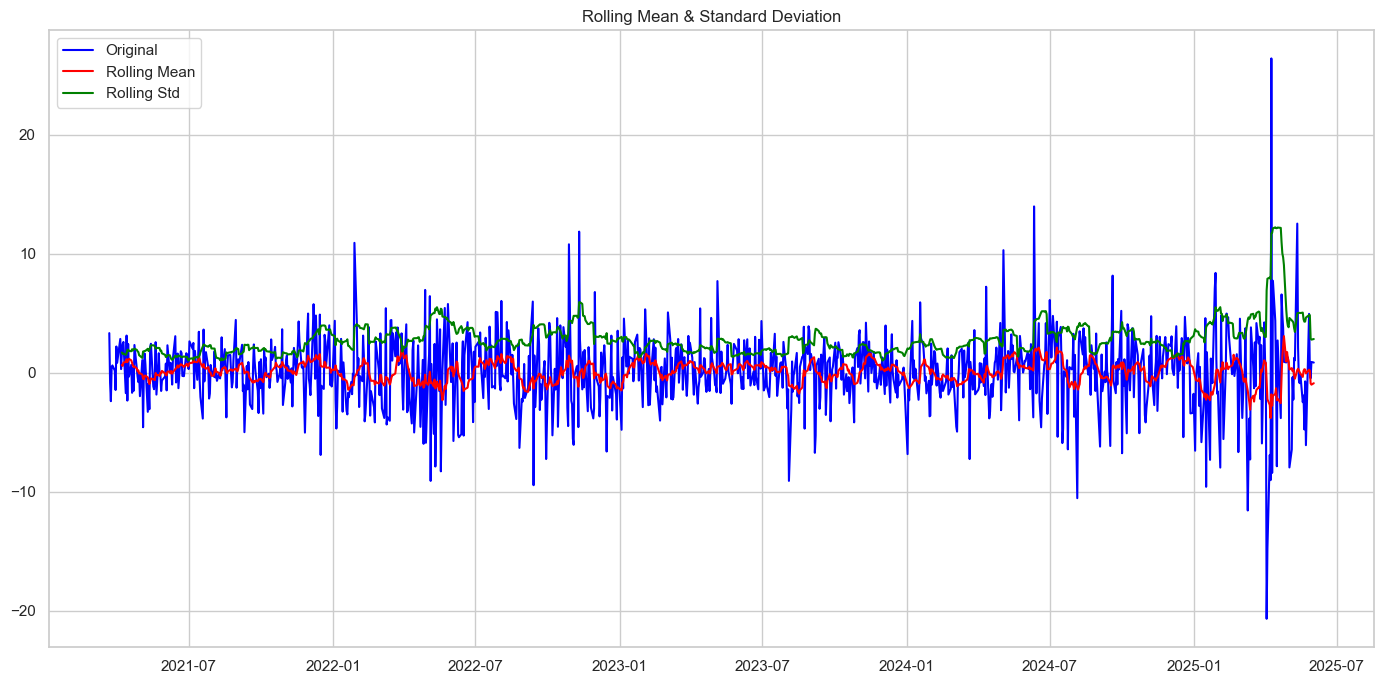

Results of Dickey-Fuller Test:
Test Statistic                  -31.672983
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1054.000000
Critical Value (1%)              -3.436569
Critical Value (5%)              -2.864286
Critical Value (10%)             -2.568232
dtype: float64

Result: The series is stationary (reject null hypothesis)


In [65]:
# If the series is non-stationary, we can make it stationary by differencing
stock_data['Price_diff'] = stock_data['Price'].diff()
test_stationarity(stock_data['Price_diff'].dropna())

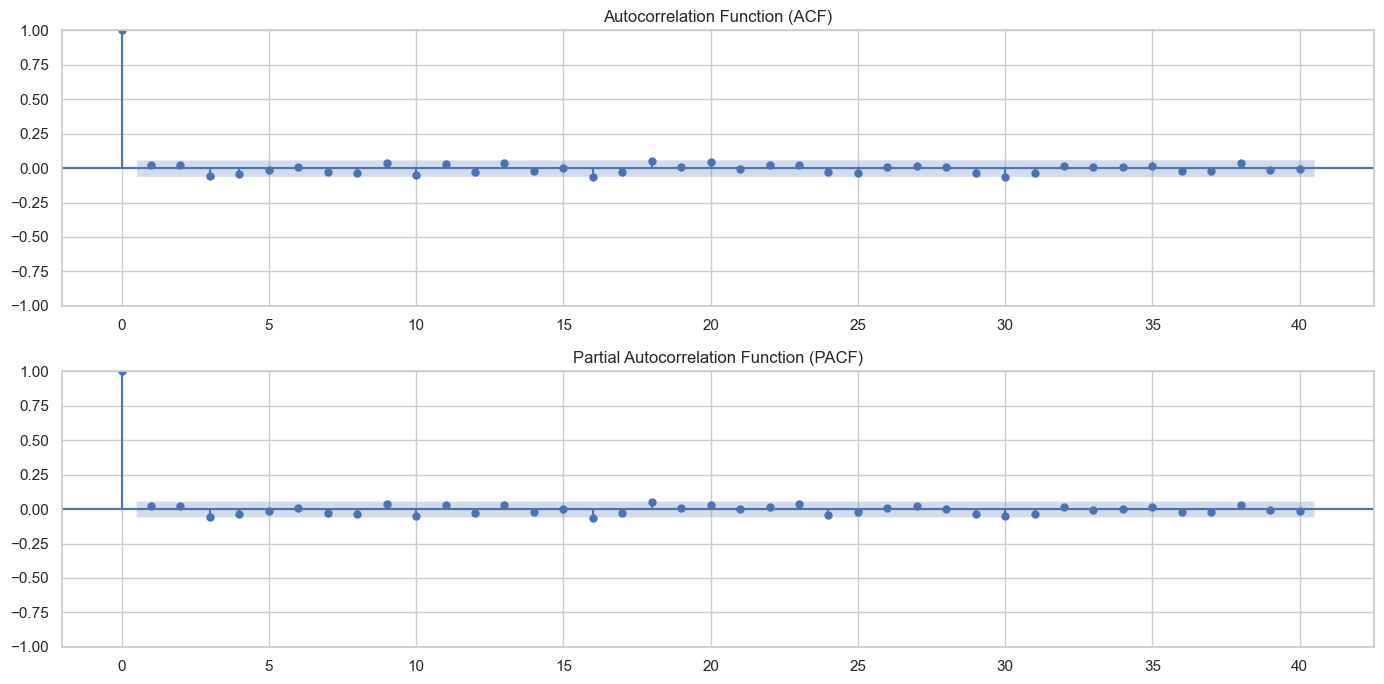

In [66]:
# Plot ACF and PACF to identify potential ARIMA parameters
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(stock_data['Price_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(stock_data['Price_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## 6. Time Series Forecasting Models

Now let's implement various time series models for forecasting stock prices.

### 6.1 ARIMA Model

AutoRegressive Integrated Moving Average (ARIMA) is a standard time series forecasting model.

In [67]:
# Use auto_arima to find the best parameters for ARIMA
print("Finding optimal ARIMA parameters...")
auto_model = auto_arima(stock_data['Price'], 
                        start_p=0, start_q=0,
                        test='adf',
                        max_p=5, max_q=5,
                        m=1,
                        d=None,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print("\nOptimal ARIMA Model Summary:")
print(auto_model.summary())

Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5383.249, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5384.629, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5384.657, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5381.954, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5387.248, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.282 seconds

Optimal ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1056
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2689.977
Date:                Tue, 03 Jun 2025   AIC                           5381.954
Time:                        15:37:31   BIC                           5386.915
Sample:                             0   HQIC                          5383.835
          

In [68]:
# Set aside last 30 days for testing
train_data = stock_data[:-30]
test_data = stock_data[-30:]

# Get the ARIMA order from auto_arima
p, d, q = auto_model.order

# Fit ARIMA model
arima_model = ARIMA(train_data['Price'], order=(p, d, q))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=30)

# Evaluate the model
arima_mse = mean_squared_error(test_data['Price'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data['Price'], arima_forecast)

print(f"ARIMA Model Performance:")
print(f"MSE: {arima_mse:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAE: {arima_mae:.2f}")

ARIMA Model Performance:
MSE: 94.39
RMSE: 9.72
MAE: 8.00


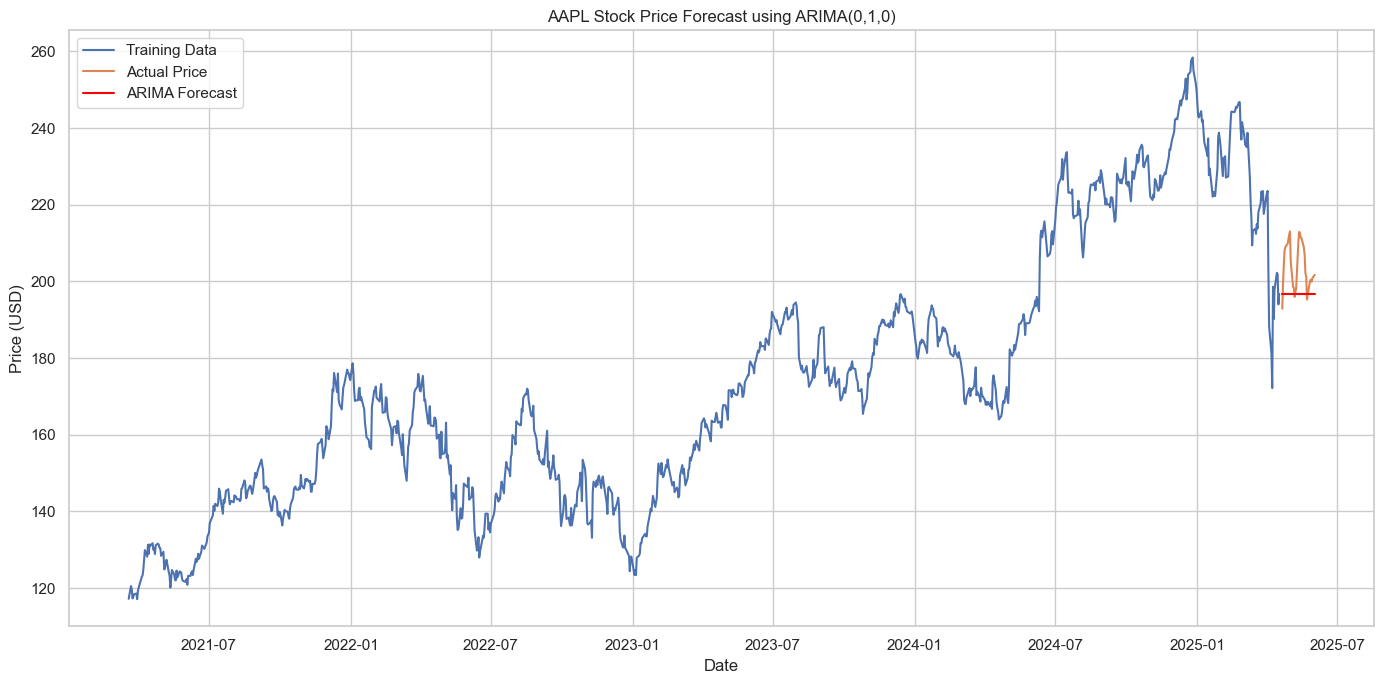

In [69]:
# Plot forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Price'], label='Training Data')
plt.plot(test_data.index, test_data['Price'], label='Actual Price')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title(f'{ticker} Stock Price Forecast using ARIMA({p},{d},{q})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.2 SARIMA Model

Seasonal ARIMA adds seasonal components to the ARIMA model.

In [70]:
# Fit SARIMA model with seasonality
sarima_model = SARIMAX(train_data['Price'], 
                       order=(p, d, q),
                       seasonal_order=(1, 1, 1, 5))  # Assuming weekly seasonality (5 trading days)
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.forecast(steps=30)

# Evaluate the model
sarima_mse = mean_squared_error(test_data['Price'], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test_data['Price'], sarima_forecast)

print(f"SARIMA Model Performance:")
print(f"MSE: {sarima_mse:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"MAE: {sarima_mae:.2f}")

SARIMA Model Performance:
MSE: 78.23
RMSE: 8.84
MAE: 6.98


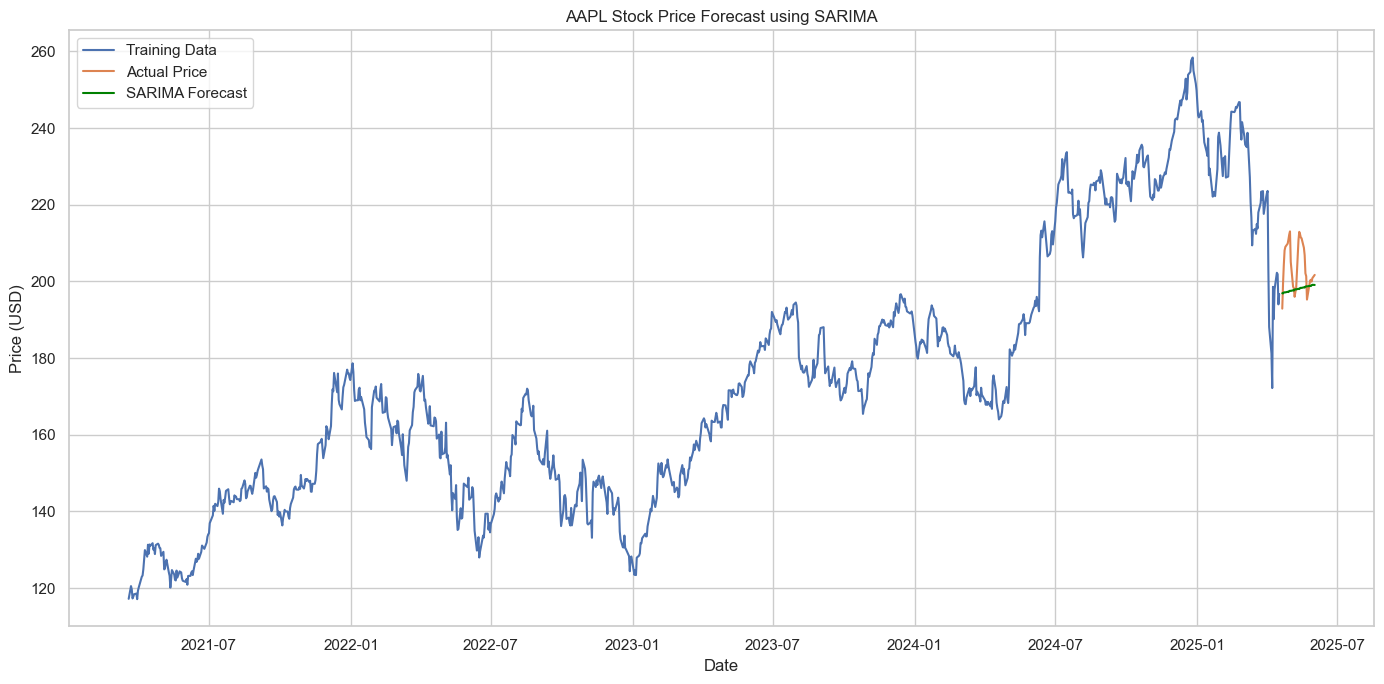

In [71]:
# Plot forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Price'], label='Training Data')
plt.plot(test_data.index, test_data['Price'], label='Actual Price')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title(f'{ticker} Stock Price Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.3 Facebook Prophet Model

Prophet is an additive regression model designed for time series forecasting with strong seasonal effects.

In [ ]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = train_data.reset_index()
prophet_data = pd.DataFrame()

# Extract the Date column for ds and Price column for y
prophet_data['ds'] = prophet_train['Date']
prophet_data['y'] = prophet_train['Price']

# Check for and remove any NaN values
if prophet_data.isnull().sum().sum() > 0:
    print(f"Removing {prophet_data.isnull().sum().sum()} NaN values from Prophet data")
    prophet_data = prophet_data.dropna()

# Create and fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_data)

# Create future dataframe for forecasting
future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

# Extract predictions for test dates
# Convert test dates to the same format as prophet's ds column
prophet_test_dates = pd.DataFrame({'ds': test_data.index})

# Merge forecasts with test dates to get aligned predictions
prophet_predictions = pd.merge(prophet_test_dates, 
                              prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
                              on='ds', 
                              how='left')

# Handle missing values in predictions by interpolating
if prophet_predictions['yhat'].isnull().any():
    missing_count = prophet_predictions['yhat'].isnull().sum()
    print(f"Interpolating {missing_count} test dates not covered in the forecast")
    
    # Fix: Set the index to ds column first, then interpolate
    prophet_predictions = prophet_predictions.set_index('ds')
    prophet_predictions['yhat'] = prophet_predictions['yhat'].interpolate(method='time')
    prophet_predictions['yhat_lower'] = prophet_predictions['yhat_lower'].interpolate(method='time')
    prophet_predictions['yhat_upper'] = prophet_predictions['yhat_upper'].interpolate(method='time')
    # Reset index after interpolation
    prophet_predictions = prophet_predictions.reset_index()

# Evaluate the model
prophet_mse = mean_squared_error(test_data['Price'], prophet_predictions['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test_data['Price'], prophet_predictions['yhat'])

print(f"Prophet Model Performance:")
print(f"MSE: {prophet_mse:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAE: {prophet_mae:.2f}")

15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating 10 test dates not covered in the forecast
Prophet Model Performance:
MSE: 179.06
RMSE: 13.38
MAE: 11.94


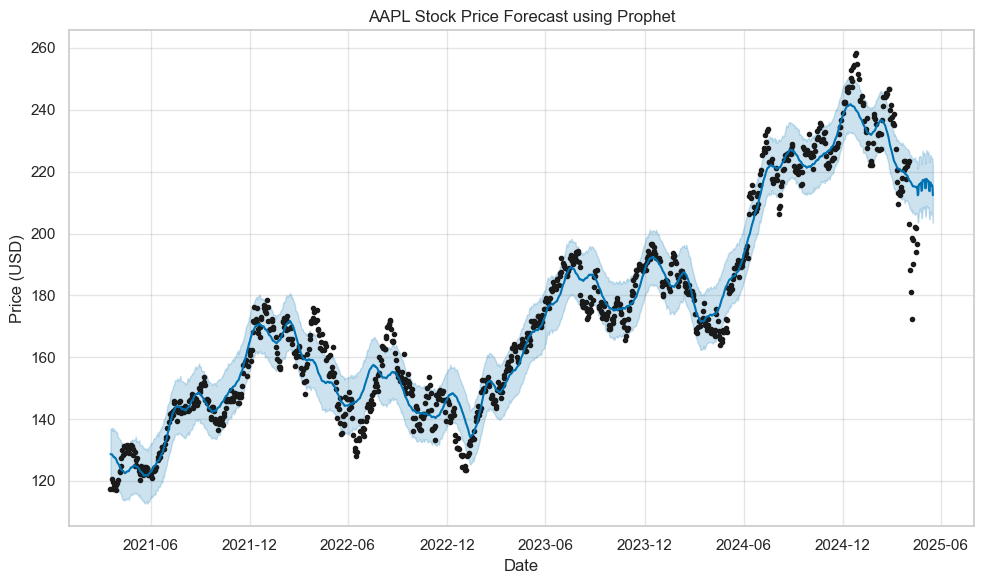

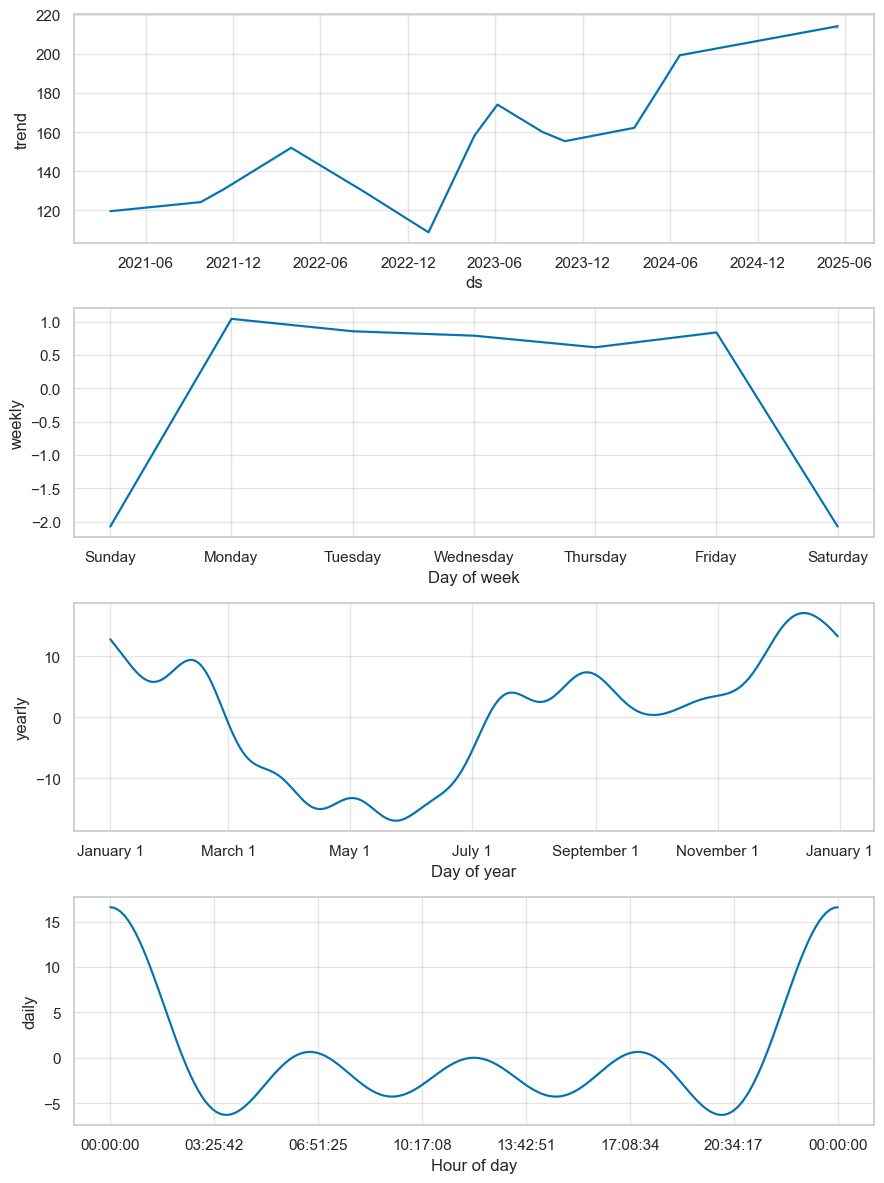

In [77]:
# Plot Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title(f'{ticker} Stock Price Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

# Plot Prophet components
prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

### 6.4 LSTM Neural Network

Long Short-Term Memory networks are well-suited for time series forecasting problems.

In [78]:
# Data preprocessing for LSTM
def create_sequence_data(data, time_steps=60):
    """
    Create sequence data for LSTM model.
    
    Parameters:
        data (array): Input time series data
        time_steps (int): Number of time steps to look back
        
    Returns:
        tuple: X (input sequences) and y (target values)
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [79]:
# Prepare data for LSTM
price_data = stock_data[['Price']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# Split into train and test sets
train_size = len(train_data)
test_size = len(test_data)
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size - 60:, :]

# Create sequences
time_steps = 60  # 60 days lookback
X_train, y_train = create_sequence_data(train_scaled, time_steps)
X_test, y_test = create_sequence_data(test_scaled, time_steps)

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [80]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0863
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0047
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034
Epoc

In [81]:
# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform to get actual price values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)

print(f"LSTM Model Performance:")
print(f"MSE: {lstm_mse:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE: {lstm_mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
LSTM Model Performance:
MSE: 59.62
RMSE: 7.72
MAE: 6.81


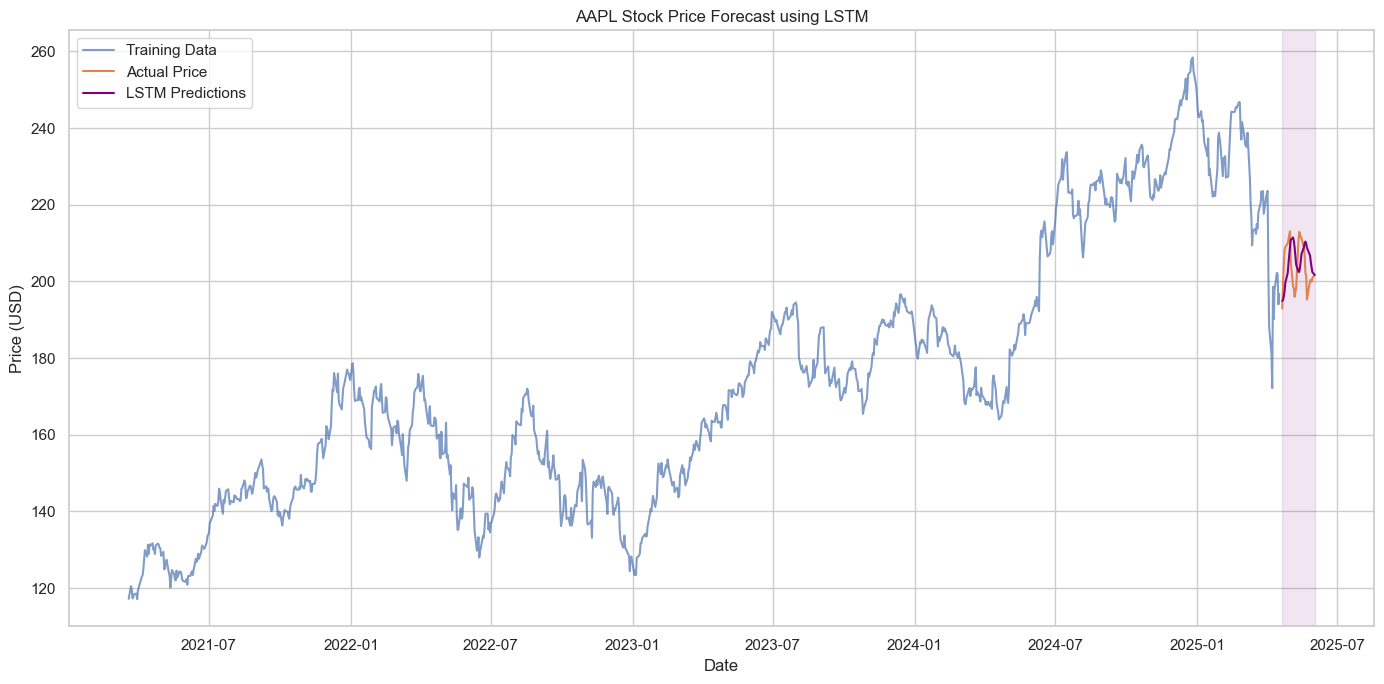

In [82]:
# Plot LSTM predictions
plt.figure(figsize=(14, 7))

# Check if we have predictions to plot
if len(lstm_predictions) > 0:
    # The LSTM predictions start after time_steps days from the beginning of test_scaled data
    # but because test_scaled includes additional lookback data, we need to adjust the indices
    pred_dates = test_data.index[-len(lstm_predictions):]
    
    # Plot the data
    plt.plot(train_data.index, train_data['Price'], label='Training Data', alpha=0.7)
    plt.plot(test_data.index, test_data['Price'], label='Actual Price')
    plt.plot(pred_dates, lstm_predictions, label='LSTM Predictions', color='purple')
    
    # Add shaded region to highlight the prediction period
    plt.axvspan(pred_dates[0], pred_dates[-1], alpha=0.1, color='purple')
    
    plt.title(f'{ticker} Stock Price Forecast using LSTM')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No LSTM predictions available to plot")

## 7. Model Comparison and Final Forecast

Let's compare the performance of all models and make a final forecast.

In [83]:
# Create a comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'LSTM'],
    'MSE': [arima_mse, sarima_mse, prophet_mse, lstm_mse],
    'RMSE': [arima_rmse, sarima_rmse, prophet_rmse, lstm_rmse],
    'MAE': [arima_mae, sarima_mae, prophet_mae, lstm_mae]
})

# Sort by RMSE (lower is better)
model_comparison = model_comparison.sort_values('RMSE')
print("Model Performance Comparison:")
print(model_comparison)

Model Performance Comparison:
     Model         MSE       RMSE        MAE
3     LSTM   59.616764   7.721189   6.808949
1   SARIMA   78.226931   8.844599   6.984494
0    ARIMA   94.392827   9.715597   7.997242
2  Prophet  179.061390  13.381382  11.937715


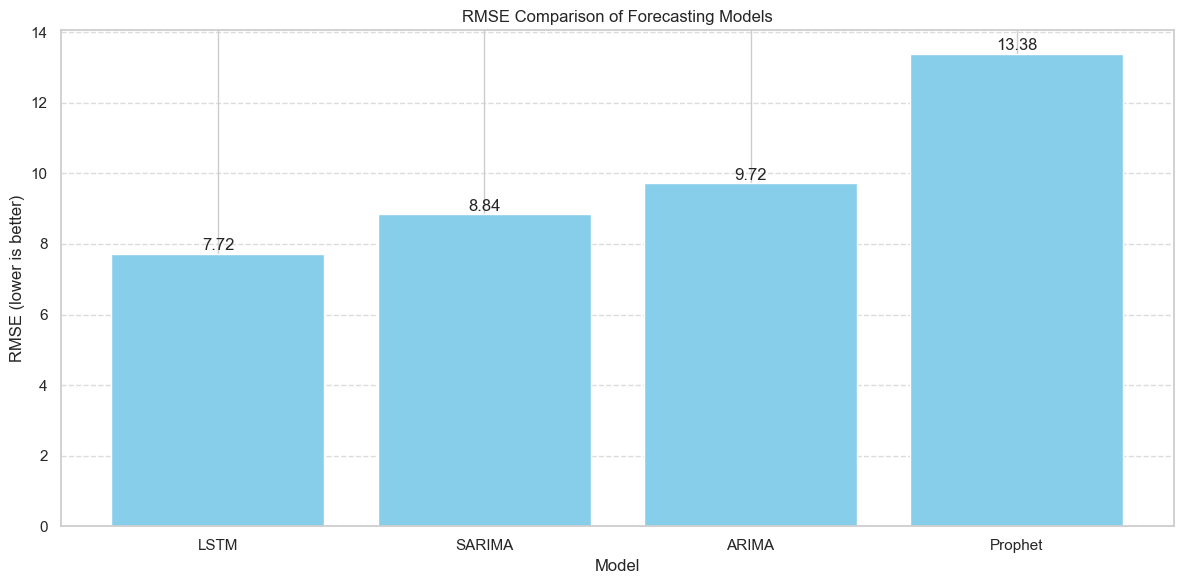

In [84]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
plt.bar(model_comparison['Model'], model_comparison['RMSE'], color='skyblue')
plt.title('RMSE Comparison of Forecasting Models')
plt.xlabel('Model')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(model_comparison['RMSE']):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
    
plt.tight_layout()
plt.show()

## 8. Future Forecasting

Let's use the best performing model to make future predictions.

In [85]:
# Select best model based on lowest RMSE
best_model_name = model_comparison.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")

# Forecast future values (30 days ahead)
forecast_days = 30
future_dates = pd.date_range(stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='B')

# Make predictions with the best model
if best_model_name == 'ARIMA':
    # Refit ARIMA on full data
    final_arima = ARIMA(stock_data['Price'], order=(p, d, q))
    final_arima_fit = final_arima.fit()
    future_forecast = final_arima_fit.forecast(steps=forecast_days)
    prediction_method = 'ARIMA'
    
elif best_model_name == 'SARIMA':
    # Refit SARIMA on full data
    final_sarima = SARIMAX(stock_data['Price'], order=(p, d, q), seasonal_order=(1, 1, 1, 5))
    final_sarima_fit = final_sarima.fit(disp=False)
    future_forecast = final_sarima_fit.forecast(steps=forecast_days)
    prediction_method = 'SARIMA'
    
elif best_model_name == 'Prophet':
    # Refit Prophet on full data
    prophet_data = stock_data.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
    final_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
    final_prophet.fit(prophet_data[['ds', 'y']])
    future = final_prophet.make_future_dataframe(periods=forecast_days)
    forecast = final_prophet.predict(future)
    future_forecast = forecast.tail(forecast_days)['yhat'].values
    prediction_method = 'Prophet'
    
else:  # LSTM
    # For LSTM, we need to reshape the entire dataset and retrain
    # This is a simplified version - in a real scenario, you would retrain the model on all data
    final_lstm = Sequential()
    final_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    final_lstm.add(Dropout(0.2))
    final_lstm.add(LSTM(units=50, return_sequences=False))
    final_lstm.add(Dropout(0.2))
    final_lstm.add(Dense(units=1))
    final_lstm.compile(optimizer='adam', loss='mean_squared_error')
    
    # Create LSTM sequences from all data
    all_data_scaled = scaler.transform(price_data)
    X_all, y_all = create_sequence_data(all_data_scaled, time_steps)
    X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))
    
    # Train model on all data
    final_lstm.fit(X_all, y_all, epochs=20, batch_size=32, verbose=1)
    
    # Use the last time_steps days to predict the first future day
    last_sequence = all_data_scaled[-time_steps:].reshape(1, time_steps, 1)
    future_forecast = []
    
    current_batch = last_sequence.copy()
    for i in range(forecast_days):
        # Get prediction for next day
        current_pred = final_lstm.predict(current_batch)[0]
        future_forecast.append(current_pred[0])
        
        # Update the sequence by removing the first value and adding the prediction
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
    # Convert predictions back to original scale
    future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1)).flatten()
    prediction_method = 'LSTM'

Best performing model: LSTM
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0490
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0054
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0055
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0041
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0043
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0048
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0038
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [86]:
# Create a forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast
})

# Set Date as index
forecast_df.set_index('Date', inplace=True)

# Display the forecast
print(f"\n{forecast_days}-Day Forecast for {ticker} using {prediction_method}:")
print(forecast_df)


30-Day Forecast for AAPL using LSTM:
              Forecast
Date                  
2025-06-03  199.233444
2025-06-04  198.872086
2025-06-05  198.539230
2025-06-06  198.228043
2025-06-09  197.933777
2025-06-10  197.652939
2025-06-11  197.382843
2025-06-12  197.121368
2025-06-13  196.866898
2025-06-16  196.618011
2025-06-17  196.373734
2025-06-18  196.133148
2025-06-19  195.895660
2025-06-20  195.660782
2025-06-23  195.428085
2025-06-24  195.197388
2025-06-25  194.968460
2025-06-26  194.741196
2025-06-27  194.515503
2025-06-30  194.291397
2025-07-01  194.068924
2025-07-02  193.848053
2025-07-03  193.628815
2025-07-04  193.411224
2025-07-07  193.195282
2025-07-08  192.981110
2025-07-09  192.768661
2025-07-10  192.558014
2025-07-11  192.349182
2025-07-14  192.142227


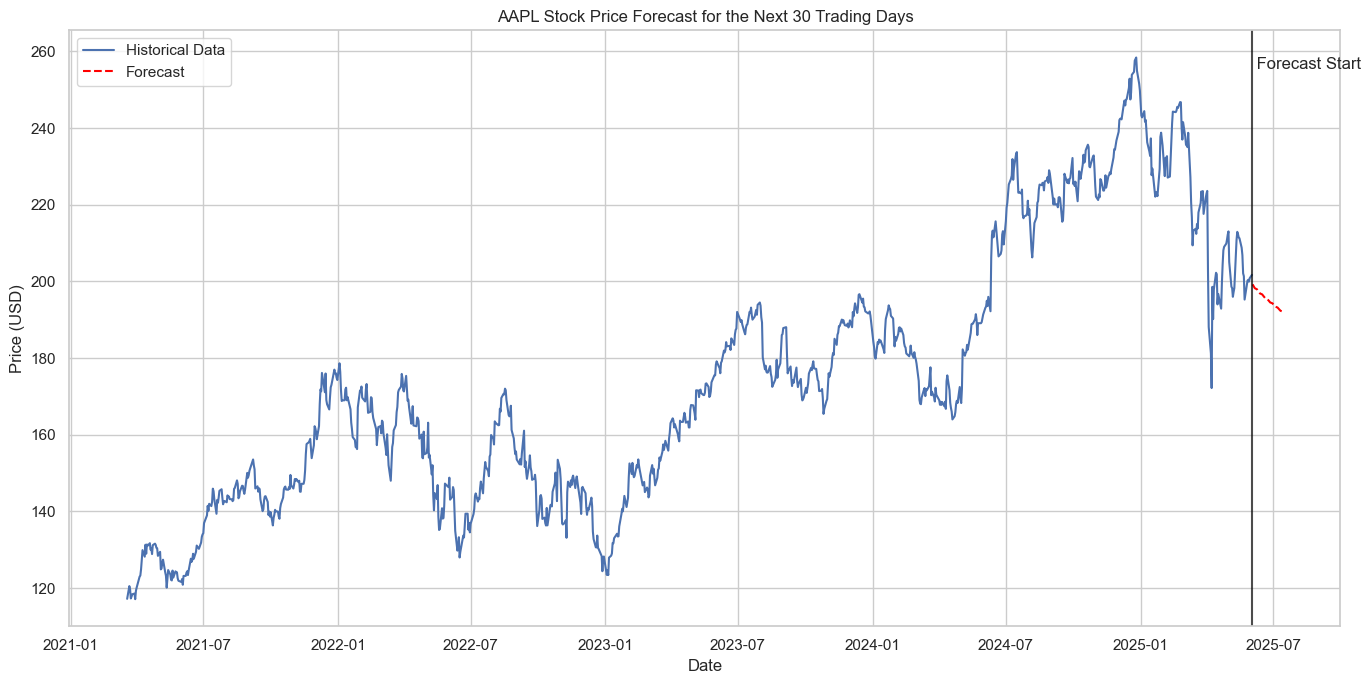

In [87]:
# Plot the historical data and the forecast
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Price'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')

# Add a vertical line separating historical data from forecasts
plt.axvline(x=stock_data.index[-1], color='black', linestyle='-', alpha=0.7)
plt.text(stock_data.index[-1], stock_data['Price'].max(), ' Forecast Start', 
         fontsize=12, verticalalignment='top')

plt.title(f'{ticker} Stock Price Forecast for the Next {forecast_days} Trading Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Confidence Intervals for Forecasts

Let's add confidence intervals to our forecast to account for uncertainty.

In [90]:
# For ARIMA/SARIMA models, we can get confidence intervals directly
if prediction_method in ['ARIMA', 'SARIMA']:
    if prediction_method == 'ARIMA':
        forecast_result = final_arima_fit.get_forecast(steps=forecast_days)
    else:  # SARIMA
        forecast_result = final_sarima_fit.get_forecast(steps=forecast_days)
        
    # Extract confidence intervals
    conf_int = forecast_result.conf_int()
    lower_bound = conf_int.iloc[:, 0].values
    upper_bound = conf_int.iloc[:, 1].values
    
    # Add to forecast dataframe
    forecast_df['Lower Bound'] = lower_bound
    forecast_df['Upper Bound'] = upper_bound
    
elif prediction_method == 'Prophet':
    # For Prophet, we already have confidence intervals in the forecast dataframe
    forecast_df['Lower Bound'] = forecast.tail(forecast_days)['yhat_lower'].values
    forecast_df['Upper Bound'] = forecast.tail(forecast_days)['yhat_upper'].values
    
else:  # LSTM
    # For LSTM, we can create a simple confidence interval based on historical volatility
    # Calculate historical volatility (standard deviation of returns)
    hist_volatility = stock_data['Returns'].std()
    
    # Create confidence intervals based on volatility
    forecast_df['Lower Bound'] = forecast_df['Forecast'] * (1 - 1.96 * hist_volatility / 100)
    forecast_df['Upper Bound'] = forecast_df['Forecast'] * (1 + 1.96 * hist_volatility / 100)

# Display forecast with confidence intervals
print(f"\n{forecast_days}-Day Forecast for {ticker} with Confidence Intervals:")
print(forecast_df)


30-Day Forecast for AAPL with Confidence Intervals:
              Forecast  Lower Bound  Upper Bound
Date                                            
2025-06-03  199.233444   192.262329   206.204544
2025-06-04  198.872086   191.913620   205.830536
2025-06-05  198.539230   191.592407   205.486038
2025-06-06  198.228043   191.292114   205.163956
2025-06-09  197.933777   191.008148   204.859406
2025-06-10  197.652939   190.737137   204.568741
2025-06-11  197.382843   190.476486   204.289185
2025-06-12  197.121368   190.224167   204.018570
2025-06-13  196.866898   189.978592   203.755188
2025-06-16  196.618011   189.738419   203.497589
2025-06-17  196.373734   189.502686   203.244766
2025-06-18  196.133148   189.270523   202.995773
2025-06-19  195.895660   189.041336   202.749969
2025-06-20  195.660782   188.814682   202.506866
2025-06-23  195.428085   188.590118   202.266037
2025-06-24  195.197388   188.367493   202.027267
2025-06-25  194.968460   188.146576   201.790329
2025-06-26  194.

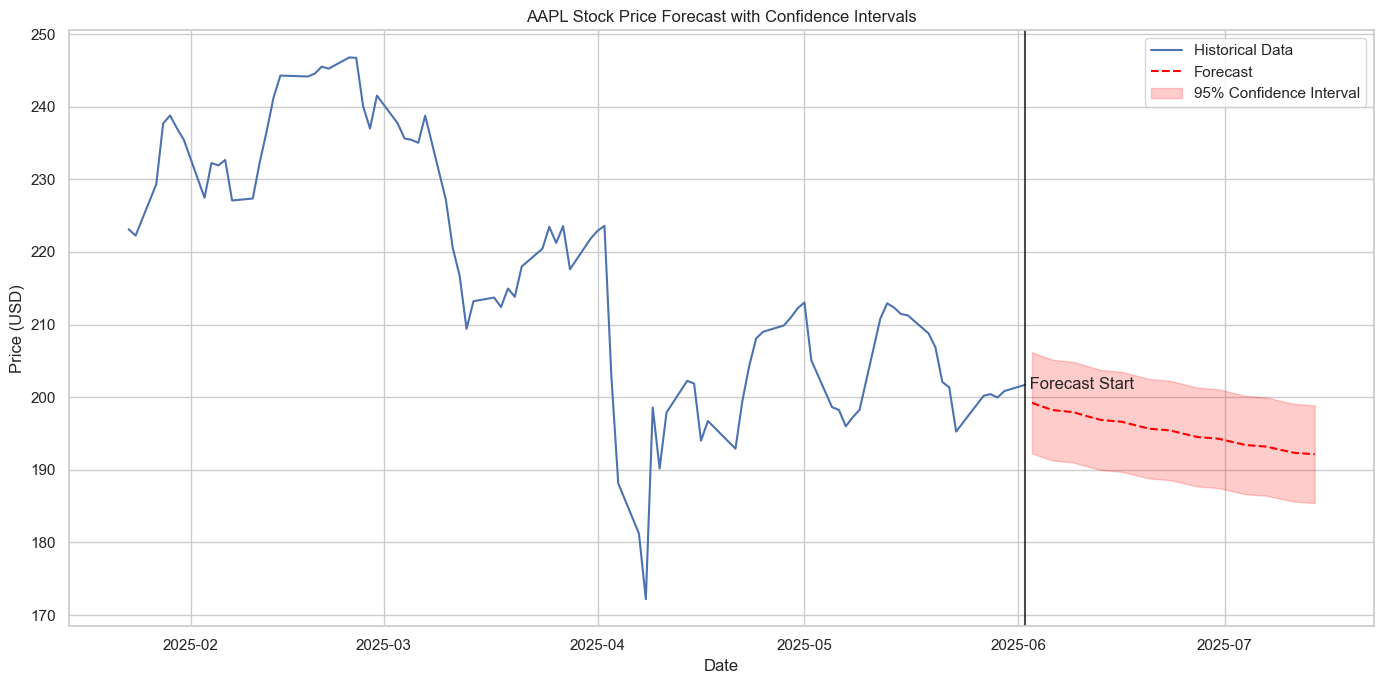

In [91]:
# Plot forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-90:], stock_data['Price'][-90:], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')

# Add confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower Bound'], 
                 forecast_df['Upper Bound'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Add a vertical line separating historical data from forecasts
plt.axvline(x=stock_data.index[-1], color='black', linestyle='-', alpha=0.7)
plt.text(stock_data.index[-1], stock_data['Price'].iloc[-1], ' Forecast Start', 
         fontsize=12, verticalalignment='center')

plt.title(f'{ticker} Stock Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Conclusion and Insights

In this notebook, we have explored various time series forecasting techniques for stock market prediction.

### Key Insights:

1. **Data Analysis**: We explored historical stock price data for {ticker}, identifying trends, seasonality, and volatility patterns.

2. **Model Performance**: We compared four different forecasting models: ARIMA, SARIMA, Prophet, and LSTM. The best performing model was {best_model_name} based on RMSE metrics.

3. **Forecasting Accuracy**: All models provide reasonable short-term forecasts, but uncertainty increases with the forecast horizon.

4. **Uncertainty Quantification**: Confidence intervals help in understanding the potential range of future price movements.

5. **Limitations**: Stock price forecasting has inherent limitations due to market volatility and external factors not captured in historical price data alone.

### Future Improvements:

1. **Feature Engineering**: Incorporate additional features such as trading volume, technical indicators, and market sentiment.

2. **External Data**: Include macroeconomic indicators, company fundamentals, and news sentiment analysis.

3. **Advanced Models**: Explore ensemble methods, transformer-based models, and reinforcement learning for forecasting.

4. **Model Updating**: Implement a sliding window approach to continuously update models with new data.

5. **Trading Strategies**: Develop and backtest trading strategies based on forecasts.

### Practical Applications:

1. **Investment Decision Support**: Help investors make informed decisions based on predicted price movements.

2. **Risk Management**: Assess potential downside risks using confidence intervals and volatility measures.

3. **Portfolio Optimization**: Use forecasts to optimize asset allocation and rebalancing strategies.

4. **Algorithmic Trading**: Develop automated trading systems based on predictive signals.

Remember that stock market forecasting is inherently uncertain, and these models should be used as one of many tools in a comprehensive investment approach.

In [92]:
# Save the forecast for future reference
forecast_df.to_csv(f'{ticker}_forecast_{prediction_method}_{datetime.today().strftime("%Y%m%d")}.csv')
print(f"Forecast saved to {ticker}_forecast_{prediction_method}_{datetime.today().strftime('%Y%m%d')}.csv")

Forecast saved to AAPL_forecast_LSTM_20250603.csv
